In [46]:
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
%matplotlib inline

## Corresponding realistic bathymetry and coordinates grid

Format of the file is specifically to develop a more refined idealized bathymetry in this notebook.

In [42]:
real_file = nc.Dataset('/ocean/imachuca/Canyons/mackenzie_canyon/bathymetry/development_sets/bathy_files/for_refine_mackenzie.nc')
z_real = real_file['Bathymetry'][:,:]
lat_s_grid = real_file['lat_s']
lon_s_grid = real_file['lon_s']

## Idealized bathymetry functions

In [47]:
def define_Mackenzie_measurements(y_extend):
    
    ''' This function defines all measurements made
    for Mackenzie Canyon that are used to create 
    the idealized bathymetry profile.
    '''
    
    # Alongshore
    w_break = 62681.735776859277  
    w_mid = 46456.969337226466  
    w_head = 14142.13562373095 
    width_f = 62681.735776859277
    x_wall = width_f * 7

    # Adjustments
    mouth = 51865.209919559762
    length = 74607.305272339116
    y_wall_1300 = 174731.93755006552 + y_extend
    y_wall = (mouth + length) * 2.57 + y_extend
    adjust = y_wall - y_wall_1300

    # Cross-shore
    cR = 9246.0
    L = 93744.0     
    y_base = np.mean([16500.0,7000.0]) + adjust 
    y_break = np.mean([38000.0, 57500.0]) + adjust 
    y_coast = 148105.0 + adjust 
    y_head = y_break + L

    # Depths
    fluid_depth = 1300.0
    z_bottom = fluid_depth - fluid_depth
    z_break = fluid_depth - 80.0
    z_wall = fluid_depth - 40.0 
    p = 4.0
    
    return w_break, w_mid, w_head, width_f, x_wall,\
            mouth, length, y_wall_1300, y_wall, adjust,\
            cR, L, y_base, y_break, y_coast, y_head,\
            fluid_depth, z_bottom, z_break, z_wall, p

# ------------------------------------------------------------------------------------

def set_domain_grid(xsize, ysize, x_wall, y_wall):
    
    ''' Sets up the domain dimensions and grid cells used
    to generate the canyon bathymetry.
    
    :arg xsize: X direction dimension (alongshore)
    :arg ysize: Y direction dimension (cross-shore)
    '''
    
    xgrd_all = np.arange(0, xsize, 1)
    xgrd_bounds = [0, xsize-1]
    xval_bounds = [0, x_wall]
    xval_all = np.interp(xgrd_all, xgrd_bounds, xval_bounds)
    x_edge = np.zeros(xsize)
    x_edge[:] = xval_all[:]
    x = ((x_edge[1:] + x_edge[0:-1])/2)

    ygrd_all = np.arange(0, ysize, 1)
    ygrd_bounds = [0, ysize-1]
    yval_bounds = [0, y_wall]
    yval_all = np.interp(ygrd_all, ygrd_bounds, yval_bounds)
    y_edge = np.zeros(ysize)
    y_edge[:] = yval_all[:]
    y = ((y_edge[1:] + y_edge[0:-1])/2)

    X, Y = np.meshgrid(x, y)
    
    return x, y, y_edge, X, Y

# ------------------------------------------------------------------------------------

def tanktopo(y, y_base, y_break, y_coast,
             fluid_depth, z_bottom, z_break, z_wall):
    
    ''' This function generates the topographical profile of the continental
    slope and shelf without the canyon. The profile is created in parts using
    the equation of a line: topography = z2 = (m * y2) - (m* y1) + z1, where
    the values for y represent key distances along the cross-shore direction
    and the values for z2 are the calculated depths based on a known z1 depth.
    '''
    
    sls_ct = (z_wall - z_break) / (y_coast - y_break)
    sls_sb = (z_break - z_bottom) / (y_break - y_base)
    topo_sp = np.zeros(len(y))
    slope_profile = np.zeros(len(y))
   
    for jj in np.arange(len(y)):

        if y[jj] > y_base and y[jj] <= y_break:
            topo_sp[jj] = (sls_sb * y[jj]) - (sls_sb * y_base) + z_bottom
                    
        elif y[jj] > y_break and y[jj] < y_coast:
            topo_sp[jj] = (sls_ct * y[jj]) - (sls_ct * y_break) + z_break
                                  
        elif y[jj] >= y_coast:
            topo_sp[jj] = z_wall

        slope_profile[jj] = topo_sp[jj] - fluid_depth
        
    return slope_profile

# ------------------------------------------------------------------------------------

def canyontopo(y, y_base, y_break, y_head, y_coast,
               fluid_depth, z_bottom, z_break, z_wall):
    
    ''' This function generates the topographical profile for the canyon along
    its axis (cross-shore direction). Similar to tanktopo, the profile is
    formed using a collection of lines.
    '''
    
    slc_L = (z_break - z_bottom) / (y_head - y_base)
    slc_ct = (z_wall - z_break) / (y_coast - y_head)
    topo_cp = np.zeros(len(y))
    canyon_profile = np.zeros(len(y))
    
    for ii in np.arange(len(y)):
        
        if y[ii] <= y_base:
            topo_cp[ii] = z_bottom
        
        elif y[ii] > y_base and y[ii] <= y_head:
            topo_cp[ii] = (slc_L * y[ii]) - (slc_L * y_base) + z_bottom
                    
        elif y[ii] > y_head and y[ii] <= y_coast :      
            topo_cp[ii] = (slc_ct * y[ii]) - (slc_ct * y_head) + z_break
          
        elif y[ii] > y_coast:
            topo_cp[ii] = z_wall
        
        canyon_profile[ii] = topo_cp[ii] - fluid_depth
 
    return canyon_profile

# ------------------------------------------------------------------------------------
   
def widthprofile(y, y_base, y_break, y_head, y_coast, cR, L,
                 w_break, w_mid, w_head, p):
    
    ''' This function defines the width profile of the canyon (top-down view).
    The width of the canyon is defined for all distances in the cross-shore
    direction. 
    '''

    sigmaa = 1.0 / ((9e-7) * cR)
    half = -w_break / 2.0+ w_mid / 2.0
    e = (L / 2.0 - sigmaa * half**2) / half**p 
    sc = 1
    dG_dxh = p * e * (w_head - w_break / 2)**(p-1) + 2 * sigmaa * (w_head - w_break)
    dh = 0.5 / dG_dxh / sc
    Ah = (w_break - w_head) / (y_base - y_head)**2;
    wp = np.zeros(len(y))

    for l in np.arange(len(y)):

            if y[l] <= y_base:
                wp[l] = w_break

            elif y[l] > y_base and y[l] <= y_head:   
                wp[l] = Ah * (y[l] - y_head)**2 + dh * (y[l] - y_head) + w_head

            elif y[l] > y_head and y[l] <= y_coast:
                wp[l] = wp[l-1]
            
            elif y[l] > y_coast:
                wp[l] = w_break
                
        
    width_profile = wp 
    return width_profile

# ------------------------------------------------------------------------------------

def make_topo_smooth(y, y_base, y_break, y_head, y_coast, cR, L,
                     x, x_wall, w_break, w_mid, w_head, p,
                     fluid_depth, z_bottom, z_break, z_wall):
    
    ''' This function returns the depth field of the continental slope and
    shelf with a sech-shaped canyon. It uses the functions tanktopo,
    canyontopo, and widthprofile.
    
    :arg y: Array of cross-shore distances
    :arg y_base: Distance to the base of the continental slope
    :arg y_break: Distance to the shelf break
    :arg y_head: Distance to the canyon head
    :arg y_coast: Distance beyond y_head where shelf flattens
    :arg cR: Radius of curvature at the shelf break depth
    :arg x: Array of alongshore distances
    :arg x_wall: Width of the Domain
    :arg w_break: Width of the canyon at the shelf break
    :arg w_mid: Width of the canyon half-way along its length
    :arg w_head: Width of the canyon head
    :arg p: Geometric parameter used to help shape of canyon
    :arg fluid_depth: Total height of the fluid in the domain.
    :arg z_bottom: Depth of the deep ocean (measured upward)
    :arg z_break: Depth of the shelf break (measured upward)
    :arg z_wall: Depth of shelf beyond y_coast (measured upward)
    '''
    
    # Topography without the canyon
    slope_profile = tanktopo(y, y_base, y_break, y_coast,
                             fluid_depth, z_bottom, z_break, z_wall)
    
    # Slope of the canyon
    canyon_profile = canyontopo(y, y_base, y_break, y_head, y_coast,
                                fluid_depth, z_bottom, z_break, z_wall)
  
    # Slope of the canyon as well as the shape
    width_profile = widthprofile(y, y_base, y_break, y_head, y_coast, cR, L,
                                 w_break, w_mid, w_head, p)
  
    # Depth of the canyon (negative values set to zero)
    canyondepth = slope_profile - canyon_profile
  
    canyondepth[canyondepth < 0] = 0
  
    # Sech shaped canyon
    topography = np.zeros((len(y),len(x)))
    for j in np.arange(len(x)):
        topography[:,j] = (slope_profile - canyondepth * 
                           (1.0 / (np.cosh(0.5 / width_profile * (x[j] - (0.5 * x_wall))))**50))
    #topography = np.transpose(topography)
    topo = -1* topography[0:-1, :]
    topo = np.fliplr(np.rot90(topo, 2))
   
    return topo

## Set up for idealized bathymetry 

Set up comes from final_bathymetry.ipynb.

In [48]:
xsize, ysize = real_bathy.shape[1] + 1, real_bathy.shape[0] + 1

extension_m = 108061
x_wall_ext = x_wall + extension_m
x_wall_ideal = x_wall_ext

In [49]:
w_break, w_mid, w_head, width_f, x_wall, mouth, length, y_wall_1300, y_wall, adjust, cR, L, y_base, y_break,\
y_coast, y_head, fluid_depth, z_bottom, z_break, z_wall, p = define_Mackenzie_measurements(y_extend)

p_one = [lon_s_grid[-1,-1], lat_s_grid[-1,-1]]
p_two = [lon_s_grid[-1,0], lat_s_grid[-1,0]]
y_wall_ideal = functions_grid.find_distance(p_one, p_two)

y_diff = y_wall_ideal - y_wall

y_base_ideal = y_base + y_diff
y_break_ideal = y_break + y_diff
y_head_ideal = y_head + y_diff
y_coast_ideal = y_coast + y_diff


x, y, y_edge, X, Y = set_domain_grid(xsize, ysize, x_wall_ideal, y_wall_ideal)

z_ideal = make_topo_smooth(y_edge, y_base_ideal, y_break_ideal, y_head_ideal, y_coast_ideal,
                                               cR, L, x, x_wall_ideal, w_break, w_mid, w_head, p,
                                               fluid_depth, z_bottom, z_break, z_wall)

<a list of 4 text.Text objects>

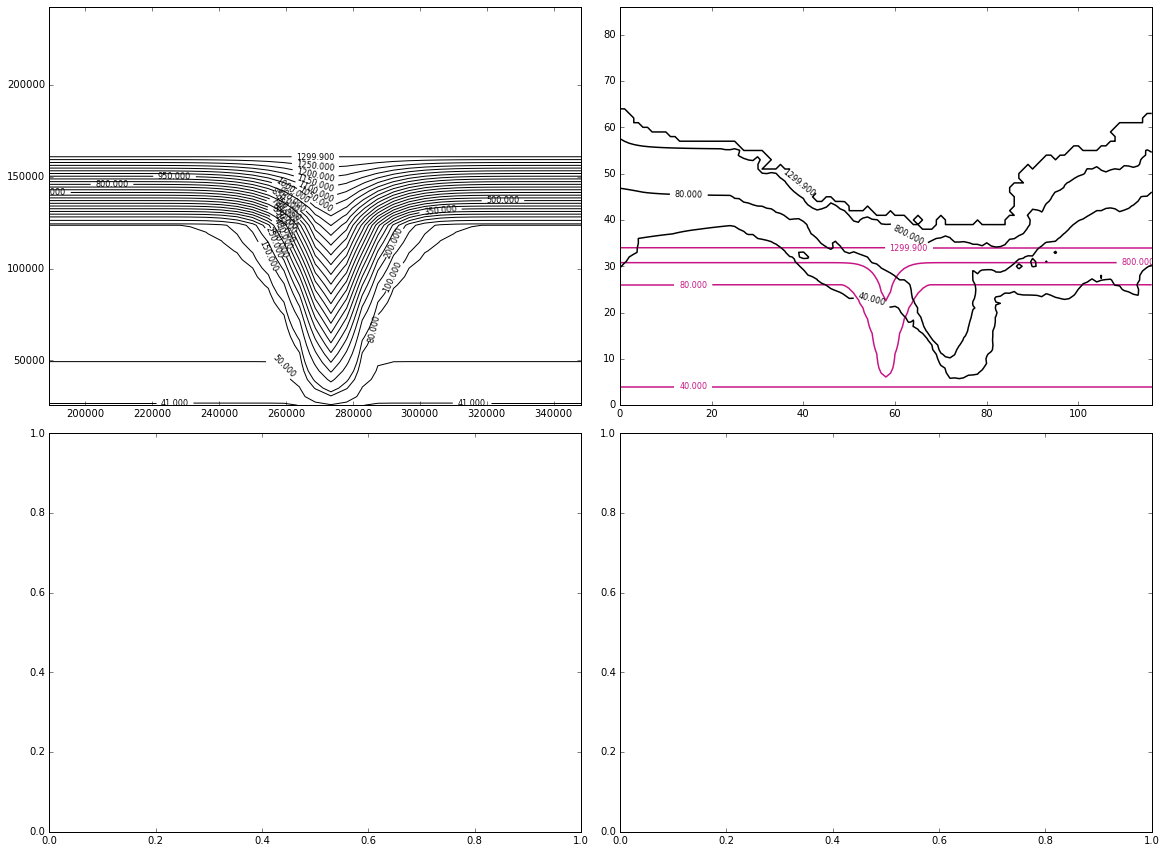

In [100]:
fig, ([ax1, ax2], [ax3, ax4]) = plt.subplots(2, 2, figsize=(16,12)); plt.tight_layout()

c0 = ax1.contour(X[5:40, 40:75], Y[5:40, 40:75], z_ideal[5:40, 40:75], 30, colors='k')
c1 = ax1.contour(X[5:40, 40:75], Y[5:40, 40:75], z_ideal[5:40, 40:75], levels = [41, 80, 1299.9], colors='k')
ax1.clabel(c0, inline=1, fontsize=8)
ax1.clabel(c1, inline=1, fontsize=8)

c2 = ax2.contour(z_ideal, levels = [0, 40, 80, 800, 1299.9], colors='mediumvioletred', linewidths=1.5)
c3 = ax2.contour(z_real, levels = [0, 40, 80, 800, 1299.9], colors='k', linewidths=1.5)
ax2.clabel(c2, inline=1, fontsize=8)
ax3.clabel(c3, inline=1, fontsize=8)
